Github Repository Link:

Objective: Correctly classify credit card transactions as either fraudulent or not fraudulent. 

Purpose: Credit card fraud is a big problem for banks that needs to be mitigated as much as possible. The bank might lose customers who experience credit card fraud, and the bank will likely have to repay the customer if fraud occurs. In the past, when I've experienced card fraud, the bank has either repaid me (in the case of debit card fraud) or voided the credit (in the case of credit card fraud). As such, being proactive in finding ways to detect whether a transaction was fraudulent is important for retaining customers and optimizing the customer experience. 

In [ ]:
# Importing necessary libraries:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [3]:
# Importing the fraud dataset 
df_train = pd.read_csv('fraudTrain.csv', index_col=0)
df_test = pd.read_csv('fraudTest.csv', index_col=0)
df_combined = pd.concat([df_train, df_test], axis=0)

In [23]:
# Taking a look at the dataframe
print(df_combined.shape)
df_combined.info()
df_combined.head()

(1852394, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 object        
 4   lat                    float64       
 5   long                   float64       
 6   merch_lat              float64       
 7   merch_long             float64       
 8   is_fraud               int64         
 9   hour                   int64         
 10  day_of_week            int64         
 11  month                  int64         
 12  hour_category          int64         
 13  day_category           int64         
 14  gender_category        int64         
 15  trans_category         object        
dtypes: datetime64[ns](1), float64(5), int64(7), object(3)
memory usage: 240.3+ MB


,trans_date_trans_time,category,amt,gender,lat,long,merch_lat,merch_long,is_fraud,hour,day_of_week,month,hour_category,day_category,gender_category,trans_category
0,2019-01-01 00:00:18,misc_net,4.97,F,36.0788,-81.1781,36.011293,-82.048315,0,0,1,1,1,0,0,misc_net
1,2019-01-01 00:00:44,grocery_pos,107.23,F,48.8878,-118.2105,49.159047,-118.186462,0,0,1,1,1,0,0,grocery_pos
2,2019-01-01 00:00:51,entertainment,220.11,M,42.1808,-112.2620,43.150704,-112.154481,0,0,1,1,1,0,1,other
3,2019-01-01 00:01:16,gas_transport,45.00,M,46.2306,-112.1138,47.034331,-112.561071,0,0,1,1,1,0,1,gas_transport
4,2019-01-01 00:03:06,misc_pos,41.96,M,38.4207,-79.4629,38.674999,-78.632459,0,0,1,1,1,0,1,other


In [ ]:
# Checking for missing values
df_combined.isna().sum()

In [ ]:
# Seeing what % of Transactions are fraudulent 
fraud_pct = len(df_combined[df_combined['is_fraud']==1])/len(df_combined) * 100

print(f'Percentage of non-fraudulent transactions: {round(100 - fraud_pct, 2)}%')
print(f'Percentage of fraudulent transactions: {round(fraud_pct, 2)}%')


Percentage of non-fraudulent transactions: 99.48%
Percentage of fraudulent transactions: 0.52%


In [ ]:
# Seeing the frequency of fraudulent transactions by various features:
print(df_combined[df_combined['is_fraud']==1].cc_num.value_counts())
print(df_combined[df_combined['is_fraud']==1].gender.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].merchant.value_counts().head(30))
print(df_combined[df_combined['is_fraud']==1].merchant.value_counts().tail(30))
print(df_combined[df_combined['is_fraud']==1].category.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].street.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].city.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].state.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].zip.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].dob.value_counts()) 
print(df_combined[df_combined['is_fraud']==1].job.value_counts().head(30)) 
print(df_combined[df_combined['is_fraud']==1].job.value_counts().tail(30)) 

4593569795412          19
4599285557366057       19
3520550088202337       19
6538441737335434       18
4260128500325          18
                       ..
6011109736646996        2
4503101193493052864     2
3518234918950662        2
6011893664860915        2
4514242065619750        2
Name: cc_num, Length: 976, dtype: int64
F    4899
M    4752
Name: gender, dtype: int64
fraud_Kilback LLC                             62
fraud_Rau and Sons                            60
fraud_Kozey-Boehm                             60
fraud_Doyle Ltd                               57
fraud_Terry-Huel                              56
fraud_Boyer PLC                               55
fraud_Kuhn LLC                                55
fraud_Kiehn-Emmerich                          53
fraud_Cormier LLC                             53
fraud_Moen, Reinger and Murphy                53
fraud_Kuhic LLC                               53
fraud_Mosciski, Ziemann and Farrell           53
fraud_Padberg-Welch                    

Based on the number of fraudulent transactions by the values in these categories, it appears that most of these are not useful in predicting whether or not a transaction is fraudulent. However, category and gender may still be useful.

In [4]:
# Dropping irrelevant features:
df_combined.drop(columns=['cc_num', 'merchant', 'city', 'street', 'job', 'state', 'zip', 'trans_num', 'city_pop', 'unix_time', 'first', 'last', 'dob'], inplace=True)
df_combined.head()


,trans_date_trans_time,category,amt,gender,lat,long,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,misc_net,4.97,F,36.0788,-81.1781,36.011293,-82.048315,0
1,2019-01-01 00:00:44,grocery_pos,107.23,F,48.8878,-118.2105,49.159047,-118.186462,0
2,2019-01-01 00:00:51,entertainment,220.11,M,42.1808,-112.2620,43.150704,-112.154481,0
3,2019-01-01 00:01:16,gas_transport,45.00,M,46.2306,-112.1138,47.034331,-112.561071,0
4,2019-01-01 00:03:06,misc_pos,41.96,M,38.4207,-79.4629,38.674999,-78.632459,0


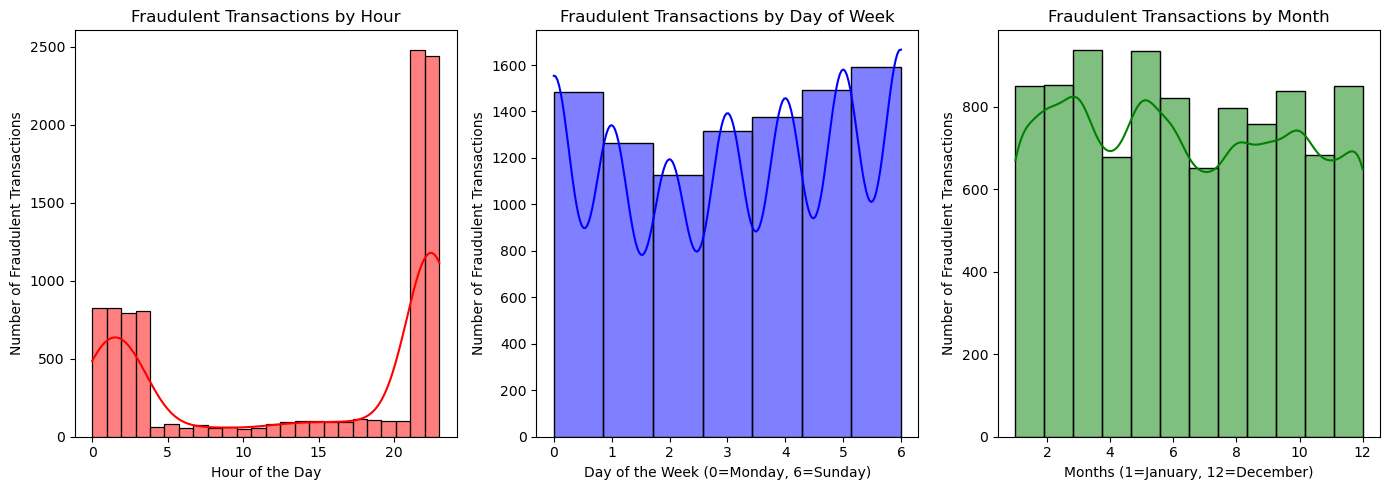

In [ ]:
# Plotting histograms based on the hour/day of week/month
# Also creates "hour", "day_of_week", and "month" columns

df_combined['trans_date_trans_time'] = pd.to_datetime(df_combined['trans_date_trans_time'])
df_combined['hour'] = df_combined['trans_date_trans_time'].dt.hour
df_combined['day_of_week'] = df_combined['trans_date_trans_time'].dt.dayofweek  # Monday=0, Sunday=6
df_combined['month'] = df_combined['trans_date_trans_time'].dt.month

fraud_df = df_combined[df_combined['is_fraud'] == 1]

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.histplot(fraud_df['hour'], bins=24, kde=True, ax=axes[0], color='red')
axes[0].set_title("Fraudulent Transactions by Hour")
axes[0].set_xlabel("Hour of the Day")
axes[0].set_ylabel("Number of Fraudulent Transactions")

sns.histplot(fraud_df['day_of_week'], bins=7, kde=True, ax=axes[1], color='blue')
axes[1].set_title("Fraudulent Transactions by Day of Week")
axes[1].set_xlabel("Day of the Week (0=Monday, 6=Sunday)")
axes[1].set_ylabel("Number of Fraudulent Transactions")

sns.histplot(fraud_df['month'], bins=12, kde=True, ax=axes[2], color='green')
axes[2].set_title("Fraudulent Transactions by Month")
axes[2].set_xlabel("Months (1=January, 12=December)")
axes[2].set_ylabel("Number of Fraudulent Transactions")

plt.tight_layout()
plt.show()

It appears that most fraudulent transactions take place between 10PM and 3AM. It also appears that more fraudulent transactions take place on Saturday/Sunday/Monday than other days of the week, but ultimately there's not a huge amount of variance between days of the week. 

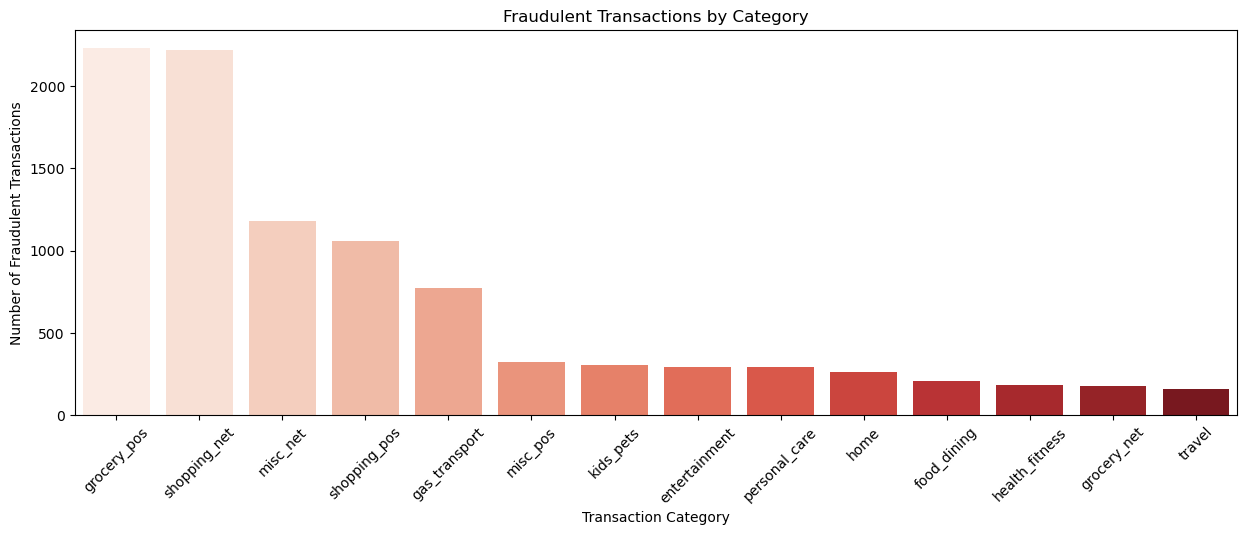

In [101]:
# Plotting histogram of fraudulent transactions based on category 

fraud_df = df_combined[df_combined['is_fraud'] == 1]

fraud_counts = fraud_df['category'].value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="Reds")

plt.xlabel("Transaction Category")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraudulent Transactions by Category")
plt.xticks(rotation=45) 
plt.show()

It appears that most of the fraudulent transactions come from "grocery_pos", "shopping_net", "misc_net", "shopping_pos", and "gas_transport". 

In [ ]:
# Now that we've taken a look at some potentially useful data points, we will transform
# the "hour", "day_of_week", "gender" and "category" columns using some helper functions:

encode = OneHotEncoder(drop='first', sparse_output=False)

def transform_hour(hour): # 1 if high-fraud hour, 0 if not
    if hour <= 3 or hour >= 22:
        return 1 
    else:
        return 0

def transform_day(day): # 1 if high-fraud day, 0 if not
    if day >= 5 or day == 0:
        return 1 
    else:
        return 0 

def transform_gender(gender): # 1 if male, 0 if female
    if gender == 'M':
        return 1 
    else:
        return 0
    
def transform_category(category): # category name if category in list below, "other" if not
    if category in ["grocery_pos", "shopping_net", "misc_net", "shopping_pos", "gas_transport"]:
        return category
    else:
        return "other"


df_combined['hour_category'] = df_combined['hour'].apply(transform_hour)
df_combined['day_category'] = df_combined['day_of_week'].apply(transform_day)
df_combined['gender_category'] = df_combined['gender'].apply(transform_gender)

# Transforming the category & applying the One-Hot Encoding 
df_combined['trans_category'] = df_combined['category'].apply(transform_category)
one_hot = pd.get_dummies(df_combined['trans_category'])

if 'other' in one_hot.columns:
    one_hot = one_hot.drop(columns=['other'])

df_encoded = pd.concat([df_combined, one_hot], axis=1)

df_encoded.head()

,trans_date_trans_time,category,amt,gender,lat,long,merch_lat,merch_long,is_fraud,hour,...,month,hour_category,day_category,gender_category,trans_category,gas_transport,grocery_pos,misc_net,shopping_net,shopping_pos
0,2019-01-01 00:00:18,misc_net,4.97,F,36.0788,-81.1781,36.011293,-82.048315,0,0,...,1,1,0,0,misc_net,0,0,1,0,0
1,2019-01-01 00:00:44,grocery_pos,107.23,F,48.8878,-118.2105,49.159047,-118.186462,0,0,...,1,1,0,0,grocery_pos,0,1,0,0,0
2,2019-01-01 00:00:51,entertainment,220.11,M,42.1808,-112.2620,43.150704,-112.154481,0,0,...,1,1,0,1,other,0,0,0,0,0
3,2019-01-01 00:01:16,gas_transport,45.00,M,46.2306,-112.1138,47.034331,-112.561071,0,0,...,1,1,0,1,gas_transport,1,0,0,0,0
4,2019-01-01 00:03:06,misc_pos,41.96,M,38.4207,-79.4629,38.674999,-78.632459,0,0,...,1,1,0,1,other,0,0,0,0,0


In [7]:
# Dropping the "hour", "day of week", "gender", "trans_date_trans_time", and "trans_categories" features:
df_encoded.drop(columns=['trans_date_trans_time', 'category', 'gender', 'hour', 'day_of_week', 'trans_category'], inplace=True)
df_encoded.head()


,amt,lat,long,merch_lat,merch_long,is_fraud,month,hour_category,day_category,gender_category,gas_transport,grocery_pos,misc_net,shopping_net,shopping_pos
0,4.97,36.0788,-81.1781,36.011293,-82.048315,0,1,1,0,0,0,0,1,0,0
1,107.23,48.8878,-118.2105,49.159047,-118.186462,0,1,1,0,0,0,1,0,0,0
2,220.11,42.1808,-112.2620,43.150704,-112.154481,0,1,1,0,1,0,0,0,0,0
3,45.00,46.2306,-112.1138,47.034331,-112.561071,0,1,1,0,1,1,0,0,0,0
4,41.96,38.4207,-79.4629,38.674999,-78.632459,0,1,1,0,1,0,0,0,0,0


In [8]:
# Min-Max Scaling the "amt", "lat", "long", "merch_lat", "merch_long", and "month" columns:
min_max = MinMaxScaler()
col = ['amt','long','lat','merch_lat','merch_long', 'month']
df_encoded[col] = min_max.fit_transform(df_encoded[col]) 
df_encoded.head()

,amt,lat,long,merch_lat,merch_long,is_fraud,month,hour_category,day_category,gender_category,gas_transport,grocery_pos,misc_net,shopping_net,shopping_pos
0,0.000137,0.343968,0.864638,0.350307,0.848603,0,0.0,1,0,0,0,0,1,0,0
1,0.003670,0.618450,0.485682,0.621490,0.486209,0,0.0,1,0,0,0,1,0,0,0
2,0.007569,0.474727,0.546553,0.497563,0.546698,0,0.0,1,0,1,0,0,0,0,0
3,0.001520,0.561509,0.548070,0.577666,0.542621,0,0.0,1,0,1,1,0,0,0,0
4,0.001415,0.394153,0.882190,0.405248,0.882857,0,0.0,1,0,1,0,0,0,0,0


In [9]:
# Moving "is_fraud" to the end of the dataframe
temp_column = df_encoded['is_fraud']
df_final = df_encoded.drop(columns=['is_fraud'])
df_final['is_fraud'] = temp_column
df_final.head()

,amt,lat,long,merch_lat,merch_long,month,hour_category,day_category,gender_category,gas_transport,grocery_pos,misc_net,shopping_net,shopping_pos,is_fraud
0,0.000137,0.343968,0.864638,0.350307,0.848603,0.0,1,0,0,0,0,1,0,0,0
1,0.003670,0.618450,0.485682,0.621490,0.486209,0.0,1,0,0,0,1,0,0,0,0
2,0.007569,0.474727,0.546553,0.497563,0.546698,0.0,1,0,1,0,0,0,0,0,0
3,0.001520,0.561509,0.548070,0.577666,0.542621,0.0,1,0,1,1,0,0,0,0,0
4,0.001415,0.394153,0.882190,0.405248,0.882857,0.0,1,0,1,0,0,0,0,0,0


In [ ]:
# Resampling the data with undersampling due to class imbalance:

X = df_final.drop(columns=['is_fraud'])
y = df_final['is_fraud']

ratio = 0.4
fraud_count = sum(y == 1)  
non_fraud_count = int(fraud_count / ratio - fraud_count)  

undersampler = RandomUnderSampler(sampling_strategy={0: non_fraud_count, 1: fraud_count}, random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X, y)

print(f"New Class Distribution:  {Counter(y_resampled)}")

14476
New Class Distribution:  Counter({0: 14476, 1: 9651})


In [ ]:
# Splitting the data into resampled training and test data and checking the proportion of positive labels in test data

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.3,stratify=y_resampled,random_state=42)
y_test[y_test==1].sum(),len(y_test)

(2896, 7239)

In [25]:
# training a Logistic Regression, Random Forest, and XGBoost Classifier

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print('Logistic Regression Classifier Results:')
print(classification_report(y_test, y_pred))
print('--------------------------------')

rfc = RandomForestClassifier(n_estimators=500, random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Random Forest Classifier Results:')
print(classification_report(y_test, y_pred))
print('--------------------------------')

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('XGBoost Classifier Results:')
print(classification_report(y_test, y_pred))

Logistic Regression Classifier Results:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4343
           1       0.75      0.77      0.76      2896

    accuracy                           0.81      7239
   macro avg       0.80      0.80      0.80      7239
weighted avg       0.81      0.81      0.81      7239

--------------------------------
Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4343
           1       0.95      0.93      0.94      2896

    accuracy                           0.95      7239
   macro avg       0.95      0.95      0.95      7239
weighted avg       0.95      0.95      0.95      7239

--------------------------------
XGBoost Classifier Results:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4343
           1       0.94      0.94      0.94      2896

    accuracy  